<a href="https://colab.research.google.com/github/davario/sector_classifier/blob/main/sector_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import sklearn.model_selection as sk

import plotly.express as px

import re

In [20]:
# Input data files are available in the "../input/" directory.
import os
print("Input files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Input files:


In [21]:
# Any results you write to the current directory are saved as output.

# For neural nets with my GPU, RNN doesn't work without this in TF 2.0
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print()
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")


TF Version:  2.4.1
Eager mode:  True
GPU is available
GPU found


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



In [22]:
from google.colab import files
uploaded = files.upload()

Saving training_data.xlsx to training_data.xlsx


In [23]:
import io
dfdata = pd.read_excel(io.BytesIO(uploaded["training_data.xlsx"]))
# Dataset is now stored in a Pandas Dataframe
dfdata.info()
print()
print(dfdata.shape)
print(dfdata.columns)
dfdata.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   NACE2              2278 non-null   object
 1   Trade_description  2278 non-null   object
dtypes: object(2)
memory usage: 35.7+ KB

(2278, 2)
Index(['NACE2', 'Trade_description'], dtype='object')


,NACE2,Trade_description
0,"D - Electricity, gas, steam and air conditioni...","La produzione, il trasporto e il commercio di ..."
1,C - Manufacturing,Das Unternehmen wurde in 1959 gegruendet. Es i...
2,G - Wholesale and retail trade; repair of moto...,Mettere a disposizione dei propri soci e della...
3,H - Transportation and storage,L'esercizio della ferrovia a scartamento ridot...
4,"R - Arts, entertainment and recreation",Promuovere e diffondere i sentimenti patriotti...


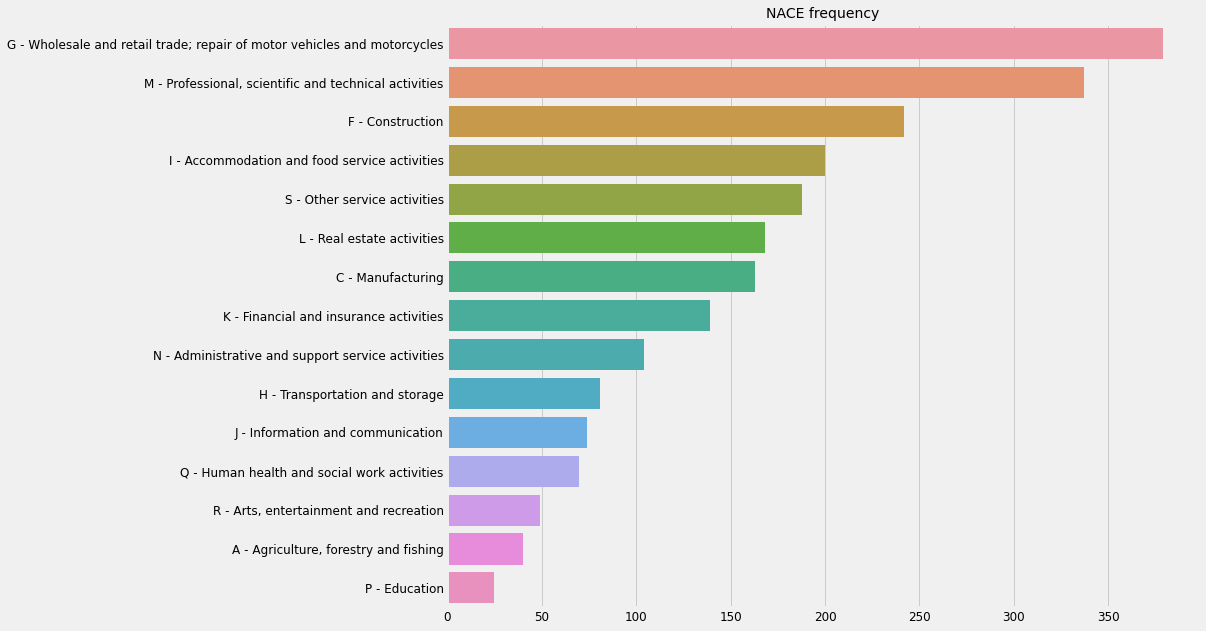

In [24]:
# Get label frequencies in descending order
label_freq = dfdata['NACE2'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.iloc[:15].index)
plt.title("NACE frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('italian')
stop

['ad',
 'al',
 'allo',
 'ai',
 'agli',
 'all',
 'agl',
 'alla',
 'alle',
 'con',
 'col',
 'coi',
 'da',
 'dal',
 'dallo',
 'dai',
 'dagli',
 'dall',
 'dagl',
 'dalla',
 'dalle',
 'di',
 'del',
 'dello',
 'dei',
 'degli',
 'dell',
 'degl',
 'della',
 'delle',
 'in',
 'nel',
 'nello',
 'nei',
 'negli',
 'nell',
 'negl',
 'nella',
 'nelle',
 'su',
 'sul',
 'sullo',
 'sui',
 'sugli',
 'sull',
 'sugl',
 'sulla',
 'sulle',
 'per',
 'tra',
 'contro',
 'io',
 'tu',
 'lui',
 'lei',
 'noi',
 'voi',
 'loro',
 'mio',
 'mia',
 'miei',
 'mie',
 'tuo',
 'tua',
 'tuoi',
 'tue',
 'suo',
 'sua',
 'suoi',
 'sue',
 'nostro',
 'nostra',
 'nostri',
 'nostre',
 'vostro',
 'vostra',
 'vostri',
 'vostre',
 'mi',
 'ti',
 'ci',
 'vi',
 'lo',
 'la',
 'li',
 'le',
 'gli',
 'ne',
 'il',
 'un',
 'uno',
 'una',
 'ma',
 'ed',
 'se',
 'perché',
 'anche',
 'come',
 'dov',
 'dove',
 'che',
 'chi',
 'cui',
 'non',
 'più',
 'quale',
 'quanto',
 'quanti',
 'quanta',
 'quante',
 'quello',
 'quelli',
 'quella',
 'quelle',
 'q

Remove italian stopwords

In [27]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('italian')


def StopWordCleanser(word):
    if word in stop:
        return ""
    else:
        return word

dfdata['Trade_description'] = dfdata['Trade_description'].map(lambda Trade_description: Trade_description.lower())
dfdata['Trade_description'] = dfdata['Trade_description'].map(lambda Trade_description: Trade_description.replace("'", " "))
dfdata['Trade_description'] = dfdata['Trade_description'].map(lambda Trade_description: Trade_description.replace(",", " "))
dfdata['Trade_description'] = dfdata['Trade_description'].apply(lambda x: " ".join([StopWordCleanser(i) for i in str(x).split()]))


In [28]:
dfdata['Trade_description'] 

0        produzione  trasporto   commercio  energia el...
1       das unternehmen wurde  1959 gegruendet. es ist...
2       mettere  disposizione  propri soci   popolazio...
3        esercizio  ferrovia  scartamento ridotto  loc...
4       promuovere  diffondere  sentimenti patriottici...
                              ...                        
2273     esercizio   impresa generale (general contrac...
2274     acquisto  vendita  consulenza  riparazione  i...
2275     gestione   spazio creativo  ambito artistico ...
2276     consulenza   realizzazione  lavori  costruzio...
2277             commercio    oggetti  servono  scrivere.
Name: Trade_description, Length: 2278, dtype: object

# New Section

In [29]:
# length of dictionary
NUM_WORDS = 5000

# Length of each description
SEQ_LEN = 250

#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, oov_token='<UNK>', filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(dfdata['Trade_description'])

#convert text data to numerical indexes
sect_seqs=tokenizer.texts_to_sequences(dfdata['Trade_description'])

#pad data up to SEQ_LEN (note that we truncate if there are more than SEQ_LEN tokens)
sect_seqs=tf.keras.preprocessing.sequence.pad_sequences(sect_seqs, maxlen=SEQ_LEN, padding="post")

print(sect_seqs)

[[  46  155   22 ...    0    0    0]
 [1530  648 4225 ...    0    0    0]
 [ 575  258  192 ...    0    0    0]
 ...
 [   8 1891 3675 ...    0    0    0]
 [  17   90   41 ...    0    0    0]
 [  22  218 1644 ...    0    0    0]]


In [ ]:

nace_labels=pd.DataFrame({'NACE2': dfdata['NACE2']})
# wine_labels=wine_labels.replace({'variety' : char2idx})
nace_labels=nace_labels.replace(' ', '_', regex=True)

nace_labels_list = []
for item in nace_labels['NACE2']:
    nace_labels_list.append(str(item))

label_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', filters='!"#$%&()*+,./:;<=>?@[\\]^`{|}~\t\n')
label_tokenizer.fit_on_texts(nace_labels_list)

label_nace = list(label_freq[label_freq>=0].index)
print(label_nace)

num_labels = len(label_nace)


print(len(label_nace))
print(label_tokenizer.word_index)

nace_label_seq = np.array(label_tokenizer.texts_to_sequences(nace_labels_list))

#wine_label_seq.reshape(129864, 1)
nace_label_seq.shape
#print(wine_label_seq)

In [31]:
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


reverse_label_index = dict([(value, key) for (key, value) in label_tokenizer.word_index.items()])

def decode_label(text):
    return ' '.join([reverse_label_index.get(i, '?') for i in text])

In [32]:
# Demonstrate what the input looks like, how it gets encoded.

test_entry=3

print(decode_article(sect_seqs[test_entry]))
print('---')
print(sect_seqs[test_entry])

print(decode_label(nace_label_seq[test_entry]))
print('---')
print(nace_label_seq[test_entry])

esercizio ferrovia scartamento ridotto locarno camedo confine italo-svizzero centovalli giusta concessione federale 23 06 1905 linea locarno-camedo ulteriori modificazioni esercizio autolinee urbane extra-urbane secondo concessioni ottenute dipartimento federale trasporti comunicazioni energie attuali future costruzione esercizio altre ferrovie filovie linee navigazione auto filobus quali società divenire concessionaria pure esercizio linee ferroviarie conto altre società proprietarie ogni altra impresa accessoria dipendente esercizio trasporti costruzione affitto acquisto terreni gestione immobili autorimesse hangar immobili deposito merci nonché costruzione esercizio impianti energetici compera energia altre imprese elettriche vendita locazione energia altre imprese ferroviarie enti pubblici persone private organizzazione promozione trasporti turistici purché tale attività svolta esclusivamente limiti scopo principale società assunzione genere qualsiasi impresa trasporto tanto canton

In [33]:
label_words=dfdata['NACE2'].unique()
number_class=len(dfdata['NACE2'].unique())
dict_nace= {i: label_words[i] for i in range(0, len(label_words))}
inv_dict_nace= {v: k for k, v in dict_nace.items()}
nace_label_seq2=dfdata['NACE2'].map(inv_dict_nace)
nace_label_seq2=pd.Series(nace_label_seq2)
nace_label_seq2=nace_label_seq2.to_frame()
nace_label_seq2=nace_label_seq2.values

nace_label_seq2.shape
nace_label_seq2=nace_label_seq2+1
print(nace_label_seq2)
len(nace_label_seq2)
print(number_class)

[[ 1]
 [ 2]
 [ 3]
 ...
 [10]
 [14]
 [ 7]]
17


In [34]:
# Divide into two
X_train, X_test, y_train, y_test = sk.train_test_split(sect_seqs,
                                                    nace_label_seq2,
                                                    test_size=0.15,
                                                    random_state=42)

print('Test: ' + str(len(X_test)) + ' Train: ' + str(len(X_train)))

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")


y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

print(type(X_train), X_train.shape)

# X_train = X_train / 1024.0
# X_test = X_test / 1024.0
# y_train = y_train / 1024.0
# y_test = y_test / 1024.0

print(X_train.shape)
print(y_train.shape)

Test: 342 Train: 1936
<class 'numpy.ndarray'> (1936, 250)
(1936, 250)
(1936, 1)


In [93]:
print(label_nace)




['G - Wholesale and retail trade; repair of motor vehicles and motorcycles', 'M - Professional, scientific and technical activities', 'F - Construction', 'I - Accommodation and food service activities', 'S - Other service activities', 'L - Real estate activities', 'C - Manufacturing', 'K - Financial and insurance activities', 'N - Administrative and support service activities', 'H - Transportation and storage', 'J - Information and communication', 'Q - Human health and social work activities', 'R - Arts, entertainment and recreation', 'A - Agriculture, forestry and fishing', 'P - Education', 'D - Electricity, gas, steam and air conditioning supply', 'E - Water supply; sewerage, waste management and remediation activities']


In [36]:
print(X_train.shape)

print(y_train.shape)
len(label_words)
print(X_test.shape)

(1936, 250)
(1936, 1)
(342, 250)


In [37]:
EMBEDDING_SIZE = 700
EMBEDDING_SIZE_2 = 700
EMBEDDING_SIZE_3 = (num_labels+1)
BATCH_SIZE = 171  # This can really speed things up
EPOCHS = 10
LR = 1e-5  # Keep it small when transfer learning

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(1, activation='relu', name='output')])
# #    tf.keras.layers.Dense(1, activation='sigmoid')])
# #    tf.keras.layers.Dense(len(idx2char), activation='relu', name='hidden_layer')])

# https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
model = tf.keras.Sequential([
    
    # Add an Embedding layer expecting input vocab of a given size, and output embedding dimension of fized size we set at the top
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE),
#     tf.keras.layers.Embedding(input_dim=NUM_WORDS, 
#                            output_dim=EMBEDDING_SIZE, 
#                            input_length=SEQ_LEN), 
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_SIZE)),
    tf.keras.layers.Conv1D(300, 5, activation='relu'), 
    tf.keras.layers.Dropout(.1, input_shape=(300,)),
    tf.keras.layers.GlobalMaxPooling1D(), 
    
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(EMBEDDING_SIZE_2, activation='relu'),
      tf.keras.layers.Dropout(0.1, input_shape=(EMBEDDING_SIZE_2,)),
    # Add a Dense layer with additional units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(EMBEDDING_SIZE_3, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
#                optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
#               loss='binary_crossentropy',
              loss='sparse_categorical_crossentropy',
#               loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 700)         3500000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 300)         1050300   
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 700)               210700    
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                1

In [38]:
steps_per_epoch = len(X_train)//BATCH_SIZE
validation_steps_num = len(X_test)//BATCH_SIZE # if you have test data
validation_steps_num


2

In [40]:
# Directory where the checkpoints will be saved
checkpoint_dir = './checkpoints/classifer_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='accuracy',
    save_best_only=True,
    mode='auto',
    save_weights_only=True)

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    validation_steps=validation_steps_num,
                   callbacks=[checkpoint_callback]
                    )

# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')
# callbacks=[es]
# history = model.fit(X_train, y_train,
#                     batch_size=BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_data=(X_test, y_test),
#                     callbacks=callbacks)

loss, accuracy = model.evaluate(X_test, y_test)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
12/12 [==============================] - 2s 154ms/step - loss: 0.0296 - accuracy: 0.9974 - val_loss: 1.4844 - val_accuracy: 0.6316
Epoch 2/10
12/12 [==============================] - 2s 146ms/step - loss: 0.0242 - accuracy: 0.9959 - val_loss: 1.4800 - val_accuracy: 0.6257
Epoch 3/10
12/12 [==============================] - 2s 146ms/step - loss: 0.0201 - accuracy: 0.9964 - val_loss: 1.5401 - val_accuracy: 0.6316
Epoch 4/10
12/12 [==============================] - 2s 146ms/step - loss: 0.0183 - accuracy: 0.9969 - val_loss: 1.4738 - val_accuracy: 0.6491
Epoch 5/10
12/12 [==============================] - 2s 144ms/step - loss: 0.0149 - accuracy: 0.9969 - val_loss: 1.5265 - val_accuracy: 0.6287
Epoch 6/10
12/12 [==============================] - 2s 144ms/step - loss: 0.0156 - accuracy: 0.9964 - val_loss: 1.5599 - val_accuracy: 0.6374
Epoch 7/10
12/12 [==============================] - 2s 145ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 1.5230 - val_accuracy: 0.6257
Epoch 

In [41]:
tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 700)         3500000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 300)         1050300   
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 700)               210700    
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                1

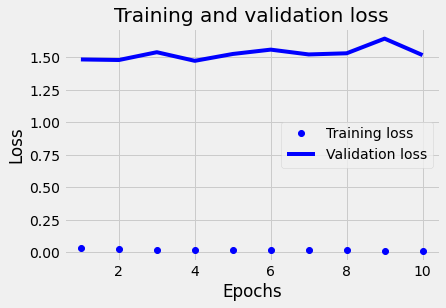

In [42]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

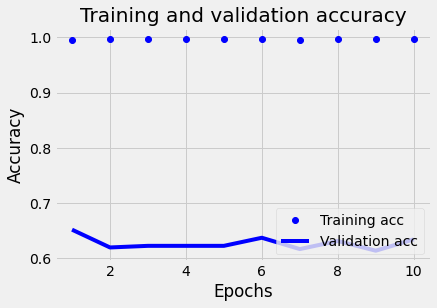

In [36]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [44]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = tokenizer.texts_to_sequences(sample_pred_text)
  print(encoded_sample_pred_text)
  print(type(encoded_sample_pred_text))

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, SEQ_LEN)
    
  encoded_sample_pred_text = np.array(encoded_sample_pred_text)
  encoded_sample_pred_text = encoded_sample_pred_text.astype("float32")
  predictions = model.predict(encoded_sample_pred_text)

In [45]:
new_review=["La fornitura di prestazioni e di assistenza nell'ambito dell'ingegneria gestionale a favore delle imprese sia in ambito pubblico che privato; il controllo e la programmazione delle attività; lo sviluppo e l'analisi di nuovi progetti e budget, e la conseguente analisi dei rischi finanziari e commerciali. Lo sviluppo di strutture manageriali ed implementazioni di business plan. La società potrà anche assumere, sia direttamente che indirettamente, interessenze e partecipazioni in altre società od imprese, così come aprire filiali e succursali, in Svizzera ed all'estero. La società potrà inoltre svolgere ogni altra operazione commerciale, finanziaria o di altro genere che sia utile a realizzare e promuovere il suo scopo sociale."]
#new_review=new_review.lower#
new_review=str(new_review)
new_review = (new_review.replace("'", " "))
new_review = new_review.replace(",", " ")
new_review = new_review.replace(".", " ")
new_review = new_review.replace(":", " ")
new_review = new_review.replace(";", " ")
new_review = new_review.replace("`", " ")


In [40]:
print(new_review)


["La fornitura di prestazioni e di assistenza nell ambito dell ingegneria gestionale a favore delle imprese sia in ambito pubblico che privato  il controllo e la programmazione delle attività  lo sviluppo e l analisi di nuovi progetti e budget  e la conseguente analisi dei rischi finanziari e commerciali  Lo sviluppo di strutture manageriali ed implementazioni di business plan  La società potrà anche assumere  sia direttamente che indirettamente  interessenze e partecipazioni in altre società od imprese  così come aprire filiali e succursali  in Svizzera ed all estero  La società potrà inoltre svolgere ogni altra operazione commerciale  finanziaria o di altro genere che sia utile a realizzare e promuovere il suo scopo sociale "]


In [46]:
new_review=[' fornitura  prestazioni   assistenza  ambito  ingegneria gestionale  favore  imprese sia  ambito pubblico  privato  controllo   programmazione  attività  sviluppo analisi  nuovi progetti  budget  conseguente analisi dei rischi finanziari  commerciali  sviluppo  strutture manageriali  implementazioni  business plan società potrà anche assumere sia direttamente  indirettamente interessenze  partecipazioni  altre società  imprese così come aprire filiali  succursali  Svizzera   estero  società potrà inoltre svolgere ogni altra operazione commerciale finanziaria  altro genere  sia utile  realizzare  promuovere  suo scopo sociale']


encoded_sample_pred_text = tokenizer.texts_to_sequences(new_review)
# Some models need padding, some don't - depends on the embedding layer.
encoded_sample_pred_text = tf.keras.preprocessing.sequence.pad_sequences(encoded_sample_pred_text, maxlen=SEQ_LEN, padding="post")
predictions = model.predict(encoded_sample_pred_text)

for n in reversed((np.argsort(predictions))[0]):
    predicted_id = [n]
    #print("Guess: %s \n Probability: %f" %(decode_label(predicted_id).replace('_', ' '), 100*predictions[0][predicted_id][0]) + '%')
    print("Guess: %s \n Probability: %f" %(dict_nace[n-1], 100*predictions[0][predicted_id][0]) + '%')

Guess: M - Professional, scientific and technical activities 
 Probability: 61.705440%
Guess: Q - Human health and social work activities 
 Probability: 16.427878%
Guess: R - Arts, entertainment and recreation 
 Probability: 7.281303%
Guess: J - Information and communication 
 Probability: 3.841067%
Guess: P - Education 
 Probability: 3.808062%
Guess: C - Manufacturing 
 Probability: 1.880310%
Guess: K - Financial and insurance activities 
 Probability: 1.375948%
Guess: D - Electricity, gas, steam and air conditioning supply 
 Probability: 1.367197%
Guess: G - Wholesale and retail trade; repair of motor vehicles and motorcycles 
 Probability: 0.889233%
Guess: E - Water supply; sewerage, waste management and remediation activities 
 Probability: 0.501839%
Guess: I - Accommodation and food service activities 
 Probability: 0.323623%
Guess: H - Transportation and storage 
 Probability: 0.198971%
Guess: S - Other service activities 
 Probability: 0.175011%
Guess: A - Agriculture, forestry 

KeyError: ignored

save model

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('/content/gdrive/MyDrive') 


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/assets


Reload model

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive')

# Check its architecture
new_model.summary()

In [50]:
dfdata['Trade_description'] 

0        produzione  trasporto   commercio  energia el...
1       das unternehmen wurde  1959 gegruendet. es ist...
2       mettere  disposizione  propri soci   popolazio...
3        esercizio  ferrovia  scartamento ridotto  loc...
4       promuovere  diffondere  sentimenti patriottici...
                              ...                        
2273     esercizio   impresa generale (general contrac...
2274     acquisto  vendita  consulenza  riparazione  i...
2275     gestione   spazio creativo  ambito artistico ...
2276     consulenza   realizzazione  lavori  costruzio...
2277             commercio    oggetti  servono  scrivere.
Name: Trade_description, Length: 2278, dtype: object

In [52]:
new_review=[' fornitura  prestazioni   assistenza  ambito  ingegneria gestionale  favore  imprese sia  ambito pubblico  privato  controllo   programmazione  attività  sviluppo analisi  nuovi progetti  budget  conseguente analisi dei rischi finanziari  commerciali  sviluppo  strutture manageriali  implementazioni  business plan società potrà anche assumere sia direttamente  indirettamente interessenze  partecipazioni  altre società  imprese così come aprire filiali  succursali  Svizzera   estero  società potrà inoltre svolgere ogni altra operazione commerciale finanziaria  altro genere  sia utile  realizzare  promuovere  suo scopo sociale']


encoded_sample_pred_text = tokenizer.texts_to_sequences(dfdata['Trade_description'] )
# Some models need padding, some don't - depends on the embedding layer.
encoded_sample_pred_text = tf.keras.preprocessing.sequence.pad_sequences(encoded_sample_pred_text, maxlen=SEQ_LEN, padding="post")
predictions = new_model.predict(encoded_sample_pred_text)

In [83]:
predictions[1]*100


array([7.96202471e-07, 2.36359220e-02, 9.97443542e+01, 3.91391478e-02,
       2.58244970e-03, 1.78130134e-03, 8.86076188e-04, 5.29664233e-02,
       6.93995098e-04, 3.83372162e-03, 2.45786650e-04, 1.26525555e-02,
       1.78660695e-02, 4.62059341e-02, 5.96674066e-03, 1.70168653e-02,
       3.49634746e-03, 2.66717486e-02], dtype=float32)

In [96]:
predictions[1][17]*100

0.026671748491935432

In [97]:
dict_nace[16]

'P - Education'

per calcolare quello con percentuale piu alta devo ora trovare come individuare la posizione dell'elemento!! questo funziona

In [108]:
dict_nace[np.argmax(predictions[1])-1]

'C - Manufacturing'

In [107]:
dict_nace[np.argmax(predictions)-1]

KeyError: ignored

In [78]:
np.argsort(predictions)[1]

array([ 0, 10,  8,  6,  5,  4, 16,  9, 14, 11, 15, 12,  1, 17,  3, 13,  7,
        2])

In [99]:

for n in reversed((np.argsort(predictions))[1]):
    predicted_id = [n]
    #print("Guess: %s \n Probability: %f" %(decode_label(predicted_id).replace('_', ' '), 100*predictions[0][predicted_id][0]) + '%')
    print("Guess: %s \n Probability: %f" %(dict_nace[n-1], 100*predictions[1][predicted_id][0]) + '%')

Guess: C - Manufacturing 
 Probability: 99.744356%
Guess: M - Professional, scientific and technical activities 
 Probability: 0.052966%
Guess: F - Construction 
 Probability: 0.046206%
Guess: G - Wholesale and retail trade; repair of motor vehicles and motorcycles 
 Probability: 0.039139%
Guess: P - Education 
 Probability: 0.026672%
Guess: D - Electricity, gas, steam and air conditioning supply 
 Probability: 0.023636%
Guess: E - Water supply; sewerage, waste management and remediation activities 
 Probability: 0.017866%
Guess: A - Agriculture, forestry and fishing 
 Probability: 0.017017%
Guess: Q - Human health and social work activities 
 Probability: 0.012653%
Guess: N - Administrative and support service activities 
 Probability: 0.005967%
Guess: K - Financial and insurance activities 
 Probability: 0.003834%
Guess: J - Information and communication 
 Probability: 0.003496%
Guess: H - Transportation and storage 
 Probability: 0.002582%
Guess: R - Arts, entertainment and recreati

KeyError: ignored

In [44]:
for n in reversed((np.argsort(predictions))[0]):
    predicted_id = [n]
    #print("Guess: %s \n Probability: %f" %(decode_label(predicted_id).replace('_', ' '), 100*predictions[0][predicted_id][0]) + '%')
    print("Guess: %s \n Probability: %f" %(dict_nace[n-1], 100*predictions[0][predicted_id][0]) + '%')

Guess: M - Professional, scientific and technical activities 
 Probability: 61.084569%
Guess: R - Arts, entertainment and recreation 
 Probability: 9.414596%
Guess: P - Education 
 Probability: 7.670005%
Guess: K - Financial and insurance activities 
 Probability: 5.560958%
Guess: D - Electricity, gas, steam and air conditioning supply 
 Probability: 4.819687%
Guess: Q - Human health and social work activities 
 Probability: 3.867610%
Guess: C - Manufacturing 
 Probability: 2.629092%
Guess: J - Information and communication 
 Probability: 2.084000%
Guess: E - Water supply; sewerage, waste management and remediation activities 
 Probability: 1.010452%
Guess: A - Agriculture, forestry and fishing 
 Probability: 0.487046%
Guess: S - Other service activities 
 Probability: 0.458745%
Guess: I - Accommodation and food service activities 
 Probability: 0.379411%
Guess: G - Wholesale and retail trade; repair of motor vehicles and motorcycles 
 Probability: 0.228005%
Guess: H - Transportation a

KeyError: ignored